
# Thresholds

Processes all info files with a certain prefix and plots various values for changing thresholds.

Only considers files that end with `-info.txt`
The info files must have the following format:
ticks: 1
numberOfBrokers: 1
numberOfLeaders: 1
nLeaderJoins: 1
nMemberJoins: 1
nMemberNotifications: 1`
latencyThreshold: 1.0


In [36]:
# imports
import pandas as pd
import seaborn as sns
import os
import glob

# vars
dir = "../simulation-result"
prefix = "sim"

# computed vars
dataDir = os.path.abspath(dir)
output = dataDir + "/" + prefix
filenames = [f for f in glob.glob(dataDir + "/" + prefix + "*-info.txt", recursive=True)]

print("{0!s} files found".format(len(filenames)))
print("Writing result to " + output)

# Configure seaborn
sns.set()
print("seaborn configured")   


160 files found
Writing result to /Users/jonathanhasenburg/git/Paper---2020---BroadcastGroups/broadcast-group-simulation/simulation-result/sim
seaborn configured


In [37]:
row_data = []
# read in file contents
for filename in filenames:
    with open(filename) as f:
        lines = f.readlines()
        
    row = {}
    for line in lines:
        line = line.replace("\n", "")
        split = line.split(": ")
        try:
            val = int(split[1])
        except ValueError:
            val = float(split[1])
        row[split[0]] = val
    row_data.append(row)
print("Parsed all files, created {0!s} rows".format(len(row_data)))


Parsed all files, created 160 rows


In [38]:
# create dataframe
df_1 = pd.DataFrame(row_data)
df_1.sort_values(by=["latencyThreshold", "numberOfBrokers"], inplace=True)
df_1.set_index("latencyThreshold", inplace=True)

# safe data
df_1.to_csv(output + ".csv")
df_1.head()

,ticks,numberOfBrokers,numberOfLeaders,nLeaderJoins,nMemberJoins,nMemberNotifications
latencyThreshold,,,,,,
10.0,40,1200,260,1070,868,998
10.0,48,2400,337,2493,2555,2985
10.0,55,3600,369,3763,4565,5097
10.0,65,4800,399,5716,7682,8997
10.0,63,6000,403,6823,9311,10537


Median join ration is 1.0407351297911414


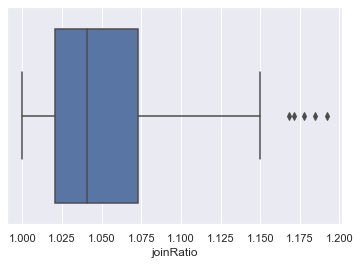

In [39]:
# calculate how many notification messages are send per member join
df_1["joinRatio"] = df_1["nMemberNotifications"] / df_1["nMemberJoins"]
print("Median join ration is " + str(df_1["joinRatio"].median()))
ax = sns.boxplot(x=df_1["joinRatio"])


Transform input data into wide format -> easier to use with seaborn


In [40]:
# move message types into own rows, and add type info
new_row_data = []
types = ["nLeaderJoins", "nMemberJoins", "nMemberNotifications"]
typeNames = {
    "nLeaderJoins": "leader joins",
    "nMemberJoins": "member joins",
    "nMemberNotifications": "member notifications"
}
for old_row in row_data:
    for type in types:
        row = {
            "latency threshold": old_row["latencyThreshold"],
            "ticks": old_row["ticks"],
            "number of brokers": old_row["numberOfBrokers"],
            "number of leaders": old_row["numberOfLeaders"],
            "amount": old_row[type],
            "operation type": typeNames[type]
        }
        new_row_data.append(row)
        
print("Moved message types into separate rows, went from {0!s} to {1!s} rows".format(len(row_data), len(new_row_data)))


Moved message types into separate rows, went from 160 to 480 rows


In [41]:
df = pd.DataFrame(new_row_data)
df.head()

,latency threshold,ticks,number of brokers,number of leaders,amount,operation type
0,70.0,100,9600,22,11325,leader joins
1,70.0,100,9600,22,37612,member joins
2,70.0,100,9600,22,39359,member notifications
3,50.0,60,2400,35,2837,leader joins
4,50.0,60,2400,35,6218,member joins


# Number of Leaders

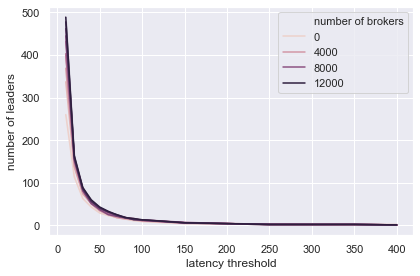

In [42]:
tmp = df
ax = sns.lineplot(data=tmp, x="latency threshold", y="number of leaders", hue="number of brokers")
fig = ax.get_figure()
fig.tight_layout()    
fig.savefig(output + "-leaders.pdf")

# Number of Ticks

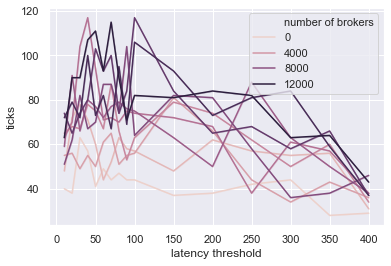

In [43]:
tmp = df
ax = sns.lineplot(data=tmp, x="latency threshold", y="ticks", hue="number of brokers")

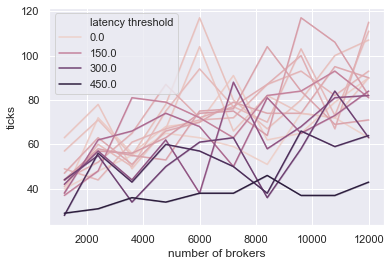

In [44]:
tmp = df
ax = sns.lineplot(data=tmp, x="number of brokers", y="ticks", hue="latency threshold")

# Number of Operations

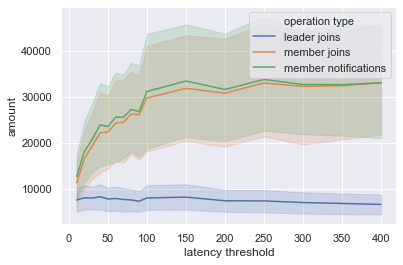

In [45]:
# the error bars are based on broker numbers
tmp = df
ax = sns.lineplot(data=tmp, x="latency threshold", y="amount", hue="operation type")


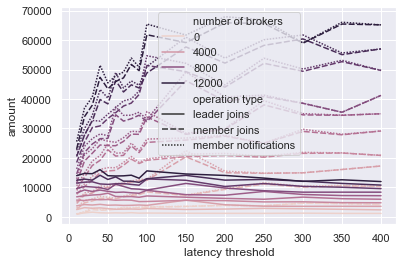

In [46]:
tmp = df
ax = sns.lineplot(data=tmp, x="latency threshold", y="amount", style="operation type", hue="number of brokers")


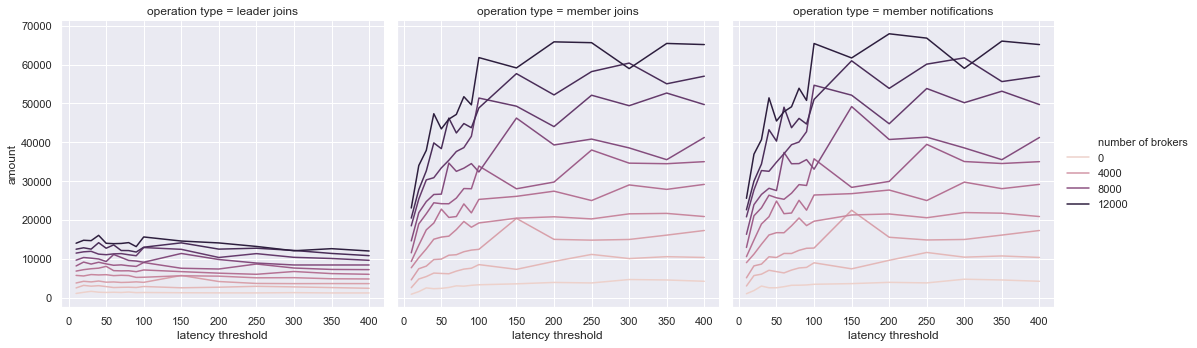

In [47]:
tmp = df
ax = sns.relplot(data=tmp, kind="line", x="latency threshold", y="amount", hue="number of brokers", col="operation type")

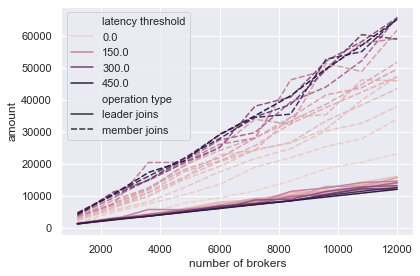

In [48]:
tmp = df[df["operation type"] != "member notifications"]
ax = sns.lineplot(data=tmp, x="number of brokers", y="amount", style="operation type", hue="latency threshold")
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig(output + "-operations.pdf")

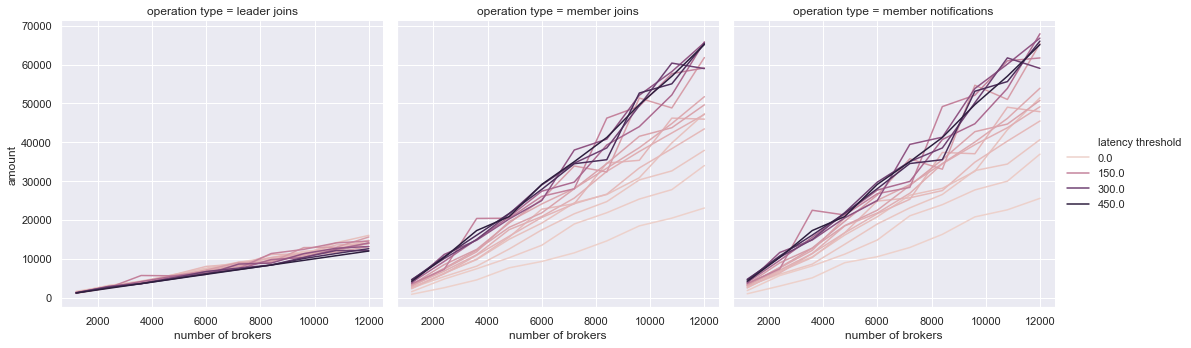

In [49]:
tmp = df
ax = sns.relplot(data=tmp, kind="line", x="number of brokers", y="amount", hue="latency threshold", col="operation type")

/anaconda3/envs/visualization/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


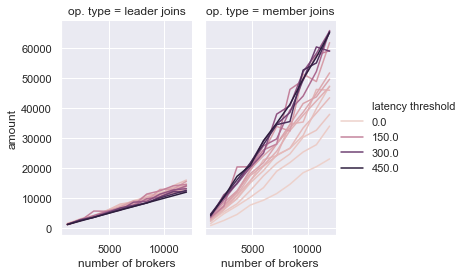

In [50]:
# influence of number of brokers on member and leader joins
tmp = df[df["operation type"] != "member notifications"]
tmp.rename(columns = {"operation type": "op. type"}, inplace=True)
fig = sns.relplot(data=tmp, kind="line", 
                  x="number of brokers", y="amount", hue="latency threshold", col="op. type", aspect=0.64, 
                  height=4)
# fig.tight_layout()    
# fig.savefig(output + "-operations.pdf")
# For the median number of joins per member notification, see boxplot above